In [1]:

import pandas as pd

# update this path if needed
path = "/Users/riyadmazari/Desktop/group project/Car details v3.csv"
df = pd.read_csv(path)

print("✅ Loaded:", len(df), "rows,", len(df.columns), "columns")
df.head()

✅ Loaded: 8128 rows, 13 columns


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
# =========================
# 2) Helper parsers
# =========================
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime
from typing import Optional, Tuple

TODAY_YEAR = datetime.now().year
pd.set_option("display.max_columns", 120)

def to_float(s: Optional[str]) -> float:
    if s is None or (isinstance(s, float) and np.isnan(s)): return np.nan
    s = str(s)
    s = re.sub(r"(?<=\d),(?=\d)", "", s)  # remove thousands commas
    m = re.search(r"[-+]?\d*\.?\d+", s)
    return float(m.group()) if m else np.nan

def parse_engine_cc(s: Optional[str]) -> float:
    # "1248 CC" -> 1248
    return to_float(s)

def parse_power_bhp(s: Optional[str]) -> float:
    # "88.5 bhp" -> 88.5
    return to_float(s)

def parse_mileage(s: Optional[str]) -> Tuple[float, str]:
    """
    Returns (value, unit) where unit in {"kmpl","km/kg","unknown"}.
    We purposely DO NOT convert kg-based mileage to kmpl to avoid unit leakage.
    """
    if s is None or (isinstance(s, float) and np.isnan(s)): return (np.nan, "unknown")
    txt = str(s).lower().strip()
    val = to_float(txt)
    if "km/kg" in txt:
        unit = "km/kg"
    elif "kmpl" in txt or "km/l" in txt:
        unit = "kmpl"
    else:
        unit = "unknown"
    return (val, unit)

def parse_torque(s: Optional[str]) -> Tuple[float, float]:
    """
    Returns (torque_nm, rpm_midpoint)
    Handles: "190Nm@ 2000rpm", "22.4 kgm at 1750-2750rpm", "12.7@ 2,700(kgm@ rpm)"
    """
    if s is None or (isinstance(s, float) and np.isnan(s)): return (np.nan, np.nan)
    raw = str(s).lower().replace(" at ", " @ ")
    is_kgm = "kgm" in raw or "kg m" in raw

    t_val = to_float(raw)
    t_nm = t_val * 9.80665 if (is_kgm and not np.isnan(t_val)) else t_val

    # rpm single or range
    rpm = np.nan
    # patterns: "@ 2000rpm", "@ 1500-2500rpm", or "1750-2750rpm"
    m_range = re.search(r"@ *(\d+)\s*-\s*(\d+)\s*rpm", raw)
    m_single = re.search(r"@ *(\d+)\s*rpm", raw)
    m_range2 = re.search(r"(\d+)\s*-\s*(\d+)\s*rpm", raw)
    m_single2 = re.search(r"(\d+)\s*rpm", raw)

    if m_range:
        a, b = map(int, m_range.groups()); rpm = (a+b)/2
    elif m_single:
        rpm = float(m_single.group(1))
    elif m_range2:
        a, b = map(int, m_range2.groups()); rpm = (a+b)/2
    elif m_single2:
        rpm = float(m_single2.group(1))

    return (t_nm, rpm)

def normalize_owner(s: Optional[str]) -> str:
    if s is None or (isinstance(s, float) and np.isnan(s)): return "Unknown"
    s = str(s).strip().title()
    mapping = {
        "First Owner":"First",
        "Second Owner":"Second",
        "Third Owner":"Third+",
        "Fourth & Above Owner":"Third+",
        "Test Drive Car":"TestDrive",
    }
    return mapping.get(s, s)

def split_make_model(name: Optional[str]) -> Tuple[str, str, str]:
    """
    Returns (make, model, model_trim) where:
      - make = first token
      - model = next token(s) until engine-like codes; conservative
      - model_trim = name without make (used for grouping to reduce leakage)
    """
    if name is None or (isinstance(name, float) and np.isnan(name)): 
        return ("Unknown","Unknown","Unknown")
    parts = str(name).split()
    make = parts[0]
    model_trim = " ".join(parts[1:]) if len(parts)>1 else "Unknown"
    # a lighter "model" (first 2 tokens) to reduce cardinality
    model = " ".join(parts[1:3]) if len(parts)>2 else (parts[1] if len(parts)>1 else "Unknown")
    return (make, model, model_trim)


In [4]:
# =========================
# 3) Core cleaning & feature engineering
# =========================

df_clean = df.copy()

# Strip obvious whitespace strings
for c in ["name","fuel","seller_type","transmission","owner","mileage","engine","max_power","torque"]:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].astype(str).str.strip().replace({"nan": np.nan})

# Parse name -> make / model / model_trim (grouping key)
df_clean[["make","model","model_trim"]] = df_clean["name"].apply(
    lambda s: pd.Series(split_make_model(s))
)

# Numeric parses
df_clean["engine_cc"]  = df_clean["engine"].apply(parse_engine_cc)
df_clean["power_bhp"]  = df_clean["max_power"].apply(parse_power_bhp)

mil_parsed = df_clean["mileage"].apply(parse_mileage)
df_clean["mileage_value"] = [v for v, u in mil_parsed]
df_clean["mileage_unit"]  = [u for v, u in mil_parsed]

torq_parsed = df_clean["torque"].apply(parse_torque)
df_clean["torque_nm"]  = [t for t, r in torq_parsed]
df_clean["torque_rpm"] = [r for t, r in torq_parsed]

# Owner normalization
df_clean["owner_simple"] = df_clean["owner"].apply(normalize_owner)

# Age feature (guard future years)
df_clean["car_age"] = (TODAY_YEAR - df_clean["year"]).clip(lower=0)

# Interaction/ratios (guard divide-by-zero)
df_clean["bhp_per_litre"] = df_clean["power_bhp"] / (df_clean["engine_cc"]/1000.0)
df_clean["nm_per_litre"]  = df_clean["torque_nm"] / (df_clean["engine_cc"]/1000.0)

# Logs (safe log1p)
for col in ["selling_price","km_driven","engine_cc","power_bhp","torque_nm"]:
    df_clean[f"log_{col}"] = np.log1p(df_clean[col])

# Basic missingness report
print("=== Missingness (%):")
print((df_clean.isna().mean()*100).sort_values(ascending=False).round(1))


=== Missingness (%):
torque_rpm           8.2
log_torque_nm        2.7
torque_nm            2.7
torque               2.7
nm_per_litre         2.7
bhp_per_litre        2.7
engine_cc            2.7
seats                2.7
engine               2.7
mileage              2.7
log_engine_cc        2.7
mileage_value        2.7
log_power_bhp        2.7
power_bhp            2.7
max_power            2.6
log_selling_price    0.0
log_km_driven        0.0
car_age              0.0
owner_simple         0.0
name                 0.0
mileage_unit         0.0
year                 0.0
model                0.0
make                 0.0
owner                0.0
transmission         0.0
seller_type          0.0
fuel                 0.0
km_driven            0.0
selling_price        0.0
model_trim           0.0
dtype: float64


In [5]:
# =========================
# 4) EDA (text)
# =========================

print("\n=== TARGET: selling_price ===")
print(df_clean["selling_price"].describe())

num_cols = [
    "year","car_age","km_driven","engine_cc","power_bhp","torque_nm",
    "mileage_value","torque_rpm","seats","bhp_per_litre","nm_per_litre",
    "log_selling_price","log_km_driven","log_engine_cc","log_power_bhp","log_torque_nm"
]
print("\n=== NUMERIC SUMMARY ===")
print(df_clean[num_cols].describe().T)

cat_cols = ["fuel","seller_type","transmission","owner_simple","mileage_unit","make"]
print("\n=== CATEGORICAL COUNTS ===")
for c in cat_cols:
    print(f"\n[{c}]")
    print(df_clean[c].value_counts(dropna=False))

# Simple plausibility checks
issues = []
if (df_clean["selling_price"]<=0).any(): issues.append("Non-positive selling_price.")
if (df_clean["km_driven"]<=0).any(): issues.append("Non-positive km_driven.")
if (df_clean["year"]>TODAY_YEAR).any(): issues.append("Future 'year' values.")
if (df_clean["engine_cc"].dropna()>8000).any(): issues.append("engine_cc > 8000 (check units).")
if (df_clean["power_bhp"].dropna()>800).any(): issues.append("power_bhp > 800 (check units).")
if (df_clean["mileage_value"].dropna()>60).any(): issues.append("mileage_value > 60 (unit issue?).")
print("\n=== DATA QUALITY FLAGS ===")
print(issues if issues else "No obvious rule-based issues.")



=== TARGET: selling_price ===
count    8.128000e+03
mean     6.382718e+05
std      8.062534e+05
min      2.999900e+04
25%      2.549990e+05
50%      4.500000e+05
75%      6.750000e+05
max      1.000000e+07
Name: selling_price, dtype: float64

=== NUMERIC SUMMARY ===
                    count          mean           std          min  \
year               8128.0   2013.804011      4.044249  1983.000000   
car_age            8128.0     11.195989      4.044249     5.000000   
km_driven          8128.0  69819.510827  56550.554958     1.000000   
engine_cc          7907.0   1458.625016    503.916303   624.000000   
power_bhp          7912.0     91.517919     35.822499     0.000000   
torque_nm          7906.0    181.025910    116.281748    47.071920   
mileage_value      7907.0     19.418783      4.037145     0.000000   
torque_rpm         7462.0   2871.858550    999.483074     0.000000   
seats              7907.0      5.416719      0.959588     2.000000   
bhp_per_litre      7906.0     63

In [6]:
# =========================
# 6) Outlier diagnostics (non-destructive)
# =========================

def iqr_outlier_mask(series, k=1.5):
    s = series.dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return (series < lower) | (series > upper)

outlier_cols = ["selling_price","km_driven","engine_cc","power_bhp","torque_nm"]
outlier_report = {}
for c in outlier_cols:
    m = iqr_outlier_mask(df_clean[c])
    outlier_report[c] = int(m.sum())

print("=== OUTLIERS (IQR, k=1.5) ===")
for k,v in outlier_report.items():
    print(f"{k}: {v} rows flagged")

# Keep flags as features for robust models (optional)
for c in outlier_cols:
    df_clean[f"flag_outlier_{c}"] = iqr_outlier_mask(df_clean[c]).astype(int)


=== OUTLIERS (IQR, k=1.5) ===
selling_price: 600 rows flagged
km_driven: 170 rows flagged
engine_cc: 1183 rows flagged
power_bhp: 570 rows flagged
torque_nm: 433 rows flagged


In [7]:
# =========================
# 7) DATA HANDLING & PREPARATION (no modeling here)
#     - fix invalid zeros -> NaN
#     - optional winsorization (heavy tails)
#     - normalize seats, rpm
#     - re-compute derived features
#     - build a reusable preprocessing pipeline for clustering/ML
# =========================

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ---------- 7.1 Fix invalid values based on EDA ----------
# Your EDA shows some zeros that are not physically meaningful for used cars.
# We'll convert those to NaN so imputers can handle them (safer than keeping zeros).

# km_driven can be 1 (very small) for new-ish entries; keep as-is.
# But set clearly invalid zeros to NaN for these:
zero_to_nan_cols = {
    "power_bhp": 0.0,
    "mileage_value": 0.0,
    "torque_rpm": 0.0,
}
for col, bad_val in zero_to_nan_cols.items():
    if col in df_clean.columns:
        n_before = df_clean[col].isna().sum()
        df_clean.loc[df_clean[col] == bad_val, col] = np.nan
        n_after = df_clean[col].isna().sum()
        print(f"[fix-zero] {col}: converted {(n_after - n_before)} zeros to NaN")

# Seats sanity: your data has min 2 and max 14. We'll cap seats to [2, 9] and set out-of-range to NaN (to impute).
if "seats" in df_clean.columns:
    mask_bad_seats = (df_clean["seats"] < 2) | (df_clean["seats"] > 9)
    n_bad_seats = int(mask_bad_seats.sum())
    df_clean.loc[mask_bad_seats, "seats"] = np.nan
    print(f"[seats] set {n_bad_seats} out-of-range seats to NaN for imputation")

# RPM sanity: very high or zero rpm is unhelpful; already set zero->NaN.
# Clip unrealistically high rpm to 6000 (diesel/petrol torque peaks rarely exceed this).
if "torque_rpm" in df_clean.columns:
    hi_rpm_cap = 6000.0
    over_cap = (df_clean["torque_rpm"] > hi_rpm_cap).sum()
    if over_cap:
        df_clean["torque_rpm"] = df_clean["torque_rpm"].clip(upper=hi_rpm_cap)
        print(f"[rpm] clipped {over_cap} rows at > {hi_rpm_cap} rpm")

# ---------- 7.2 Optional winsorization (caps heavy tails but keeps all rows) ----------
APPLY_WINSOR = True  # set False to skip capping

winsor_cols = ["selling_price","km_driven","engine_cc","power_bhp","torque_nm"]
winsor_limits = {  # 1%/99% quantile caps (tweak if needed)
    c: (0.01, 0.99) for c in winsor_cols
}

def winsorize_inplace(df_in: pd.DataFrame, limits: dict):
    for c, (lo_q, hi_q) in limits.items():
        if c not in df_in.columns:
            continue
        lo, hi = df_in[c].quantile(lo_q), df_in[c].quantile(hi_q)
        before_low  = int((df_in[c] < lo).sum())
        before_high = int((df_in[c] > hi).sum())
        df_in[c] = df_in[c].clip(lower=lo, upper=hi)
        if before_low + before_high:
            print(f"[winsor] {c}: capped {before_low} low and {before_high} high values")

if APPLY_WINSOR:
    winsorize_inplace(df_clean, winsor_limits)

# ---------- 7.3 Recompute derived features (keep consistent after edits) ----------
if set(["power_bhp","engine_cc"]).issubset(df_clean.columns):
    df_clean["bhp_per_litre"] = df_clean["power_bhp"] / (df_clean["engine_cc"] / 1000.0)

if set(["torque_nm","engine_cc"]).issubset(df_clean.columns):
    df_clean["nm_per_litre"] = df_clean["torque_nm"] / (df_clean["engine_cc"] / 1000.0)

for col in ["selling_price","km_driven","engine_cc","power_bhp","torque_nm"]:
    if col in df_clean.columns:
        df_clean[f"log_{col}"] = np.log1p(df_clean[col])

# ---------- 7.4 Light de-duplication (keeps the first occurrence) ----------
# Using a conservative subset; adjust if you find exact duplicates
dedupe_keys = [c for c in ["name","year","km_driven","fuel","transmission"] if c in df_clean.columns]
if dedupe_keys:
    before = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=dedupe_keys, keep="first").reset_index(drop=True)
    print(f"[dedupe] dropped {before - len(df_clean)} duplicate rows (keys: {dedupe_keys})")

# ---------- 7.5 Final feature lists for downstream use ----------
# Numeric features (safe & informative)
num_features = [
    "car_age","km_driven","engine_cc","power_bhp","torque_nm",
    "mileage_value","torque_rpm","seats","bhp_per_litre","nm_per_litre",
    # Logs help distance-based models; include, but you can toggle later
    "log_km_driven","log_engine_cc","log_power_bhp","log_torque_nm",
]

# Categorical features (coarser to reduce leakage)
cat_features = ["fuel","transmission","owner_simple","mileage_unit","make"]

# Guard for missing columns
num_features = [c for c in num_features if c in df_clean.columns]
cat_features = [c for c in cat_features if c in df_clean.columns]

print(f"[features] numeric={len(num_features)} | categorical={len(cat_features)}")

# ---------- 7.6 Build a reusable preprocessing pipeline ----------
# - Median impute + Standardize numeric
# - Most-frequent impute + OneHot for categoricals
# - Rare levels consolidated via min_frequency if available (sklearn >=1.1)

try:
    ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=0.01)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore")

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

prep_for_clustering = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_features),
        ("cat", categorical_pipe, cat_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Fit-transform once to materialize a clean design matrix (for EDA checks or clustering later)
X_prepared = prep_for_clustering.fit_transform(df_clean[num_features + cat_features])

print("X_prepared shape:", X_prepared.shape)

# ---------- 7.7 Optional: quick sanity prints ----------
print("\n[post-clean] Missingness (%) of key numeric:")
print((df_clean[num_features].isna().mean()*100).round(2).sort_values(ascending=False).head(10))

print("\nSample of cleaned columns:")
print(df_clean[["name","year","selling_price","km_driven","fuel","transmission","engine_cc","power_bhp","mileage_value","seats"]].head(5))


[fix-zero] power_bhp: converted 6 zeros to NaN
[fix-zero] mileage_value: converted 17 zeros to NaN
[fix-zero] torque_rpm: converted 31 zeros to NaN
[seats] set 20 out-of-range seats to NaN for imputation
[winsor] selling_price: capped 74 low and 79 high values
[winsor] km_driven: capped 79 low and 80 high values
[winsor] engine_cc: capped 31 low and 78 high values
[winsor] power_bhp: capped 47 low and 80 high values
[winsor] torque_nm: capped 29 low and 79 high values
[dedupe] dropped 1606 duplicate rows (keys: ['name', 'year', 'km_driven', 'fuel', 'transmission'])
[features] numeric=14 | categorical=5
X_prepared shape: (6522, 39)

[post-clean] Missingness (%) of key numeric:
torque_rpm       9.32
seats            3.33
mileage_value    3.27
power_bhp        3.05
torque_nm        3.05
bhp_per_litre    3.05
nm_per_litre     3.05
log_power_bhp    3.05
log_torque_nm    3.05
engine_cc        3.04
dtype: float64

Sample of cleaned columns:
                           name  year  selling_price

/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in m

K= 3 | silhouette=0.2552 | CH=1837.4 | DB=1.475
K= 4 | silhouette=0.2372 | CH=1599.2 | DB=1.507


/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-

K= 5 | silhouette=0.2557 | CH=1613.8 | DB=1.390
K= 6 | silhouette=0.2501 | CH=1406.6 | DB=1.505


/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-

K= 7 | silhouette=0.2376 | CH=1355.2 | DB=1.499
K= 8 | silhouette=0.2116 | CH=1260.2 | DB=1.548


/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-

K= 9 | silhouette=0.1888 | CH=1198.6 | DB=1.632
K=10 | silhouette=0.1876 | CH=1136.2 | DB=1.608


/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-

K=11 | silhouette=0.1754 | CH=1044.3 | DB=1.697
K=12 | silhouette=0.1902 | CH=1035.8 | DB=1.523

Chosen K (silhouette): 5 (sil=0.2557)

=== Car cluster sizes ===
car_cluster
0    2072
1    1475
2    1766
3     685
4     524
Name: count, dtype: int64

=== Car cluster profiles (medians + top categories) ===
   cluster  count  med_car_age  med_km_driven  med_engine_cc  med_power_bhp  \
0        0   2072         10.0        73750.0         1396.0           88.5   
1        1   1475         15.0        90000.0         1172.0           67.1   
2        2   1766          9.0        30000.0         1197.0           81.8   
3        3    685         10.0        70000.0         2179.0          147.8   
4        4    524         13.0       116000.0         2498.0          100.0   

   med_mileage_value  med_seats                                     top_fuel  \
0              22.70        5.0                     Diesel(2062), Petrol(10)   
1              18.00        5.0  Petrol(1076), Diesel(337)

/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/riyadmazari/Library/Python/3.9/lib/python/site-

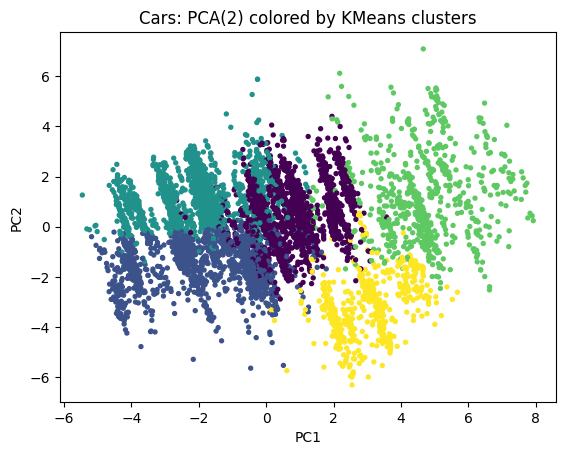

In [8]:
# =========================
# 8) CAR CLUSTERING (unsupervised on cleaned features)
#    - uses X_prepared from Section 7 (no price leakage)
#    - selects K via silhouette
#    - fits KMeans
#    - profiles clusters + 2D PCA plot
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def choose_k_kmeans(X, k_min=3, k_max=12, sample_frac=1.0, random_state=42):
    """
    Try K in [k_min, k_max], compute silhouette/CH/DB scores on a (sub)sample,
    choose best by silhouette. Works for dense or sparse matrices.
    """
    rng = np.random.RandomState(random_state)
    if sample_frac < 1.0 and X.shape[0] > 2000:
        idx = rng.choice(X.shape[0], size=int(X.shape[0]*sample_frac), replace=False)
        Xs = X[idx]
    else:
        Xs = X

    # Convert to dense only for CH/DB if needed
    def maybe_dense(M):
        return M.toarray() if hasattr(M, "toarray") else M

    scores = []
    for k in range(k_min, k_max+1):
        km = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
        labels = km.fit_predict(Xs)
        sil = silhouette_score(Xs, labels, metric="euclidean")
        ch  = calinski_harabasz_score(maybe_dense(Xs), labels)
        db  = davies_bouldin_score(maybe_dense(Xs), labels)
        scores.append((k, sil, ch, db))
        print(f"K={k:2d} | silhouette={sil:.4f} | CH={ch:.1f} | DB={db:.3f}")

    best = max(scores, key=lambda t: t[1])
    print(f"\nChosen K (silhouette): {best[0]} (sil={best[1]:.4f})")
    return best[0], pd.DataFrame(scores, columns=["K","silhouette","calinski_harabasz","davies_bouldin"])

# Use the cleaned, encoded matrix from Section 7
X_car_ready = X_prepared  # alias for readability

best_k_car, kscan_car = choose_k_kmeans(X_car_ready, k_min=3, k_max=12, sample_frac=0.8)

kmeans_car = KMeans(n_clusters=best_k_car, n_init="auto", random_state=42)
car_labels = kmeans_car.fit_predict(X_car_ready)
df_clean["car_cluster"] = car_labels

print("\n=== Car cluster sizes ===")
print(df_clean["car_cluster"].value_counts().sort_index())

# ---- Cluster profiling (medians & top categories) ----
def profile_clusters(df, label_col, num_cols, cat_cols, top_n_cats=5):
    prof = []
    for c in sorted(df[label_col].unique()):
        d = df[df[label_col]==c]
        row = {"cluster": int(c), "count": int(len(d))}
        for col in num_cols:
            if col in d:
                row[f"med_{col}"] = float(np.nanmedian(d[col]))
        for col in cat_cols:
            if col in d:
                vc = d[col].value_counts(dropna=False).head(top_n_cats)
                row[f"top_{col}"] = ", ".join([f"{k}({v})" for k,v in vc.items()])
        prof.append(row)
    return pd.DataFrame(prof).sort_values("cluster")

car_profiles = profile_clusters(
    df_clean, "car_cluster",
    num_cols=["car_age","km_driven","engine_cc","power_bhp","mileage_value","seats"],
    cat_cols=["fuel","transmission","owner_simple","make"]
)
print("\n=== Car cluster profiles (medians + top categories) ===")
print(car_profiles)

# ---- 2D visualization via PCA ----
pca = PCA(n_components=2, random_state=42)
X_car_pca = pca.fit_transform(X_car_ready.toarray() if hasattr(X_car_ready,"toarray") else X_car_ready)

plt.scatter(X_car_pca[:,0], X_car_pca[:,1], c=car_labels, s=8)
plt.title("Cars: PCA(2) colored by KMeans clusters")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


In [12]:
# =========================
# USER CLUSTERING (robust, tiny-sample safe) + mapping to car clusters
# Requirements already defined earlier:
#   - df_clean, num_features, cat_features
#   - prep_for_clustering  (fitted on cars)
#   - kmeans_car           (fitted KMeans on cars)
# =========================

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances_argmin_min

# --- helper: ensure dense & finite to avoid runtime warnings ---
def to_dense_finite(X):
    from scipy import sparse
    X = X.toarray() if sparse.issparse(X) else np.asarray(X, dtype=np.float64)
    return np.nan_to_num(X, copy=False, posinf=0.0, neginf=0.0)

# --- build user features aligned to car feature space ---
def build_user_aligned_df(user_df: pd.DataFrame) -> pd.DataFrame:
    """
    Expected user_df columns (examples):
      budget, annual_km, seats_needed,
      fuel_preference, transmission_pref,
      power_importance (0-10), efficiency_importance (0-10),
      age_tolerance_years, brand_inclination
    """
    uf = user_df.copy()

    # normalize 'Any' to NaN (lets imputers handle)
    for c in ["fuel_preference","transmission_pref","brand_inclination"]:
        if c in uf.columns:
            uf[c] = uf[c].replace({"Any": np.nan, "any": np.nan})

    # map preferences into car-like numeric features
    uf["car_age"]   = uf["age_tolerance_years"].astype(float)
    uf["km_driven"] = uf["annual_km"].astype(float) * 3.0
    uf["seats"]     = uf["seats_needed"].astype(float)

    # power / efficiency targets via dataset quantiles
    p25, p50, p75 = np.nanpercentile(df_clean["power_bhp"], [25,50,75])
    m25, m50, m75 = np.nanpercentile(df_clean["mileage_value"], [25,50,75])
    uf["power_bhp"]     = np.where(uf["power_importance"]>=7, p75,
                             np.where(uf["power_importance"]>=4, p50, p25))
    uf["mileage_value"] = np.where(uf["efficiency_importance"]>=7, m75,
                             np.where(uf["efficiency_importance"]>=4, m50, m25))

    # categorical alignment
    uf["fuel"]         = uf.get("fuel_preference", pd.Series([np.nan]*len(uf)))
    uf["transmission"] = uf.get("transmission_pref", pd.Series([np.nan]*len(uf)))
    uf["make"]         = uf.get("brand_inclination", pd.Series([np.nan]*len(uf)))

    # fill any remaining required numeric/cat columns with NaN (imputers will handle)
    for c in num_features:
        if c not in uf.columns:
            uf[c] = np.nan
    for c in cat_features:
        if c not in uf.columns:
            uf[c] = np.nan

    # compute logs when possible
    if "log_km_driven" in num_features:
        uf["log_km_driven"] = np.log1p(uf["km_driven"])
    if "log_power_bhp" in num_features:
        uf["log_power_bhp"] = np.log1p(uf["power_bhp"])
    # engine_cc / torque_nm unknown for users => leave NaN; imputer will fill
    # log_engine_cc / log_torque_nm remain NaN and will be imputed too

    # ensure column order matches the preprocessor
    aligned = uf[num_features + cat_features].copy()
    return aligned

# --- safe K selection for small user sample sizes ---
def choose_k_kmeans_safe(X, k_min=2, k_max=8, random_state=42):
    X = to_dense_finite(X)
    n = X.shape[0]
    k_min = max(2, k_min)
    k_max = min(k_max, max(2, n-1))  # silhouette needs ≤ n-1

    results = []
    for k in range(k_min, k_max+1):
        km = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
        labels = km.fit_predict(X)
        # defensively compute metrics
        try:
            sil = silhouette_score(X, labels) if 2 <= len(set(labels)) <= n-1 else np.nan
        except Exception:
            sil = np.nan
        try:
            ch = calinski_harabasz_score(X, labels)
        except Exception:
            ch = np.nan
        try:
            db = davies_bouldin_score(X, labels)
        except Exception:
            db = np.nan
        results.append((k, sil, ch, db))
        print(f"K={k:2d} | silhouette={sil if not np.isnan(sil) else 'NA'} | CH={ch if not np.isnan(ch) else 'NA'} | DB={db if not np.isnan(db) else 'NA'}")

    # prefer silhouette when available, else Calinski–Harabasz
    valid_sil = [r for r in results if not np.isnan(r[1])]
    if valid_sil:
        best = max(valid_sil, key=lambda t: t[1])
    else:
        valid_ch = [r for r in results if not np.isnan(r[2])]
        best = max(valid_ch, key=lambda t: t[2]) if valid_ch else results[0]

    print(f"\nChosen K: {best[0]} (sil={best[1] if not np.isnan(best[1]) else 'NA'})")
    return best[0], pd.DataFrame(results, columns=["K","silhouette","calinski_harabasz","davies_bouldin"])

# --- main entry: cluster users + map to nearest car clusters ---
def cluster_users(user_df: pd.DataFrame, k_min=2, k_max=8, random_state=42):
    if len(user_df) < 2:
        raise ValueError("Need at least 2 users to cluster.")

    Xu_raw = build_user_aligned_df(user_df)
    Xu = prep_for_clustering.transform(Xu_raw)   # use the SAME preprocessor as cars
    Xu = to_dense_finite(Xu)

    best_k, scan = choose_k_kmeans_safe(Xu, k_min=k_min, k_max=k_max, random_state=random_state)
    kmeans_user = KMeans(n_clusters=best_k, n_init="auto", random_state=random_state)
    user_labels = kmeans_user.fit_predict(Xu)

    # map each user vector to nearest car cluster centroid (same space)
    car_centers = to_dense_finite(kmeans_car.cluster_centers_)
    nearest_car_cluster, _ = pairwise_distances_argmin_min(Xu, car_centers, metric="euclidean")

    # reporting
    sizes = pd.Series(user_labels).value_counts().sort_index()
    crosstab = pd.crosstab(user_labels, nearest_car_cluster)

    print("\n=== User cluster sizes ===")
    print(sizes)
    print("\n=== Crosstab: user_cluster vs nearest_car_cluster ===")
    print(crosstab)

    artifacts = {
        "kmeans_user": kmeans_user,
        "user_labels": user_labels,
        "nearest_car_cluster": nearest_car_cluster,
        "scan": scan,
        "aligned_user_matrix": Xu_raw.assign(_cluster=user_labels, _nearest_car_cluster=nearest_car_cluster),
    }
    return artifacts


In [11]:
# =========================
# EXPORT CLEANED + ENCODED DATASETS
# =========================
import pandas as pd
import numpy as np
from scipy import sparse
import os

os.makedirs("exports", exist_ok=True)

# --- 1. Export the cleaned human-readable dataset ---
clean_path = "exports/cleaned_cars_dataset.csv"
df_clean.to_csv(clean_path, index=False)
print(f"✅ Cleaned dataset exported to: {clean_path}")

# --- 2. Export the encoded (numerical) dataset used for ML/clustering ---
# Transform the clean data again using your fitted preprocessor
X_encoded = prep_for_clustering.transform(df_clean[num_features + cat_features])

# If it’s sparse (OneHotEncoder creates sparse output), convert to dense for CSV
if sparse.issparse(X_encoded):
    X_encoded = X_encoded.toarray()

encoded_cols = prep_for_clustering.get_feature_names_out()
df_encoded = pd.DataFrame(X_encoded, columns=encoded_cols)

encoded_path = "exports/encoded_cars_dataset.csv"
df_encoded.to_csv(encoded_path, index=False)
print(f"✅ Encoded dataset exported to: {encoded_path}")

# --- 3. Optional: combine cluster labels ---
df_combined = pd.concat([df_clean.reset_index(drop=True), df_encoded], axis=1)
df_combined_path = "exports/cars_cleaned_with_clusters_encoded.csv"
df_combined.to_csv(df_combined_path, index=False)
print(f"✅ Combined dataset (cleaned + encoded + clusters) exported to: {df_combined_path}")

# --- 4. (optional) Save also as NumPy arrays for fast loading ---
np.save("exports/X_encoded.npy", X_encoded)
np.save("exports/y_clusters.npy", df_clean["car_cluster"].to_numpy())
print("✅ NumPy arrays saved: X_encoded.npy, y_clusters.npy")


✅ Cleaned dataset exported to: exports/cleaned_cars_dataset.csv
✅ Encoded dataset exported to: exports/encoded_cars_dataset.csv
✅ Combined dataset (cleaned + encoded + clusters) exported to: exports/cars_cleaned_with_clusters_encoded.csv
✅ NumPy arrays saved: X_encoded.npy, y_clusters.npy
